In [ ]:
#@title Connections

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# Define path
path='/content/drive/MyDrive/Colab Notebooks/PADAM/'

# Check GPU Info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Mon Jan  9 02:28:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
#@title imports
!pip install adabound

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import os
import argparse

from torch.autograd import Variable

from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

import adabound

import json
from copy import deepcopy

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title VGG
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes = 10):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# net = VGG('VGG11')
# x = torch.randn(2,3,32,32)
# print(net(Variable(x)).size())


In [ ]:
#@title Padam
from torch.optim import *
import torch
import math
import numpy as np

class Padam(Optimizer):
    """Implements Partially adaptive momentum estimation (Padam) algorithm.
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-1)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        partial (float, optional): partially adaptive parameter
    """

    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True, partial = 1/4):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, partial = partial)
        super(Padam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                partial = group['partial']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom**(partial*2))
                
        return loss
    


In [ ]:
#@title utils
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
# term_width = int(term_width)
term_width=20

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(str(msg))
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


In [ ]:
#@title train_loop( ) and test_loop( )
def train_loop(trainloader, model, criterion, optimizer, use_cuda, train_errs, train_losses,epoch=None,target_epoch=None):
    # Training
    model.train()  
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        def closure():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            return loss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if epoch is None and target_epoch is None:
            optimizer.step(closure)
        else:
            optimizer.step(closure,epoch,target_epoch)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))

    # Compute training error
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))
    train_errs.append(1 - correct/total)
    train_losses.append(train_loss/(batch_idx+1))


def test_loop(testloader, model, criterion, use_cuda, test_errs, test_losses):
    # Testing
    model.eval()  
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (test_loss/(batch_idx+1), 100.0 / total * (correct), correct, total))
    test_errs.append(1 - correct/total)
    test_losses.append(test_loss/(batch_idx+1))



In [ ]:
#@title Data Loader

def load_cifar10():
    print('==> Preparing cifar10 data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=f'{path}/data/', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root=f'{path}/data/', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader


def load_cifar100():
    print('==> Preparing cifar100 data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    ])

    trainset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return trainloader, testloader



In [ ]:
#@title def train(method,lr,dataset)

def train(method,lr,dataset):

    # Hyperparameters ##############################################
    # Tuning Hyperparameters
    net="vggnet"
    wd = 5e-4
    beta1 = 0.9
    beta2 = 0.99
    Nepoch=200
    resume=True
    print(net,dataset,method)

    # init #########################################################
    results_path=f'{path}/checkpoint/{net}/{dataset}/{method}'
    use_cuda = torch.cuda.is_available()
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    train_errs = []
    test_errs = []
    train_losses = []
    test_losses = []
    lrs = []

    # Data #########################################################
    if dataset == 'CIFAR10':
        trainloader, testloader = load_cifar10()
    elif dataset == 'CIFAR100':
        trainloader, testloader = load_cifar100()
    else:
        print(f'{dataset} Not Available!')
        return 0

    # Model #########################################################
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        try:
            checkpoint = torch.load(results_path)
            model = checkpoint['model']
            start_epoch = checkpoint['epoch']
            train_losses = checkpoint['train_losses']
            train_errs = checkpoint['train_errs']
            test_losses = checkpoint['test_losses']
            test_errs = checkpoint['test_errs']
            best_acc = checkpoint['best_acc']
            lrs = checkpoint['lrs']
            lr=lrs[-1]
        except Exception as e:
            print(e)
            print('==> Building model..')
            if net == 'vggnet':
                if dataset == 'CIFAR10':
                    model = VGG('VGG16', num_classes=10)
                elif dataset == 'CIFAR100':
                    model = VGG('VGG16', num_classes = 100)
                else:
                    print(f'{dataset} model Not Available!')
                    return 0
            # #     model = models.vgg16_bn(num_classes=10)
            # elif net == 'resnet':
            #     model = ResNet18(num_classes=10)
            # #     model = models.resnet18(num_classes=10)
            # elif net == 'wideresnet':
            #     model = WResNet_cifar10(
            #         num_classes=10, depth=16, multiplier=4)
            else:
                print('Network undefined!')
    else:
        print('==> Building model..')
        if net == 'vggnet':
            if dataset == 'CIFAR10':
                model = VGG('VGG16', num_classes=10)
            elif dataset == 'CIFAR100':
                model = VGG('VGG16', num_classes = 100)
            else:
                print(f'{dataset} model Not Available!')
                return 0
        # #     model = models.vgg16_bn(num_classes=10)
        # elif net == 'resnet':
        #     model = ResNet18(num_classes=10)
        # #     model = models.resnet18(num_classes=10)
        # elif net == 'wideresnet':
        #     model = WResNet_cifar10(
        #         num_classes=10, depth=16, multiplier=4)
        else:
            print('Network undefined!')

    if use_cuda:
        model.cuda()
        model = torch.nn.DataParallel(
            model, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True

    # Optimize/Train #####################################
    criterion = nn.CrossEntropyLoss()
    betas = (beta1, beta2)

    if method == 'sgdm':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= 0.9, weight_decay = wd)
    elif method == 'sgdm_dampening=0.9':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= 0.9, dampening=0.9,weight_decay = wd)
    elif method == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd, betas = betas)
    elif method == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = wd, betas = betas)
    elif method == 'amsgrad':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad = True, weight_decay = wd, betas = betas)
    elif method == 'adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=lr, final_lr=0.1)
    elif method == 'padam':
        optimizer = Padam(model.parameters(), lr=lr, partial = partial, weight_decay = wd, betas = betas)
    else:
        print ('Optimizer undefined!')

    milestones=[100-start_epoch,150-start_epoch]
    print([i for i in milestones if i>0])
    scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

    for epoch in range(start_epoch+1, Nepoch+1):
        print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr(), ' best_acc: ', best_acc)
        # Train
        train_loop(trainloader=trainloader, model=model, 
                    criterion=criterion, optimizer=optimizer,
                    use_cuda=use_cuda,train_errs=train_errs,train_losses=train_losses)
        # Test
        test_loop(testloader=testloader, model=model, criterion=criterion, 
                  use_cuda=use_cuda, test_errs=test_errs, test_losses=test_losses)
        # Save checkpoint
        acc = 100.0 * (1-test_errs[-1])
        if acc > best_acc:
            best_acc = acc
        lrs.extend(scheduler.get_last_lr())
        print('Saving..')
        state = {
            'model': model,
            'epoch': epoch,
            'best_acc': best_acc,
            'train_errs': train_errs,
            'train_losses': train_losses,
            'test_errs': test_errs,
            'test_losses': test_losses,
            'lrs': lrs
        }
        torch.save(state, results_path)

        scheduler.step()



In [ ]:
train(method='sgdm',lr=0.1,dataset='CIFAR100')

vggnet CIFAR100 sgdm
==> Preparing cifar100 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/PADAM//checkpoint/vggnet/CIFAR100/sgdm'
==> Building model..
[100, 150]

Epoch: 1  Learning rate: [0.1]  best_acc:  0
 [================================================================>]  Step: 662ms | Tot: 30s915ms | Loss: 4.776 | Acc: 1.262% (631/50000) 391/391 
 [================================================================>]  Step: 22ms | Tot: 13s529ms | Loss: 4.567 | Acc: 1.460% (730/50000) 391/391 
 [================================================================>]  Step: 21ms | Tot: 2s882ms | Loss: 4.560 | Acc: 1.540% (154/10000) 100/100 
Saving..

Epoch: 2  Learning rate: [0.1]  best_acc:  1.539999999999997
 [================================================================>]  Step: 68ms | Tot: 30s651ms | Loss: 4.537 | Acc: 1.660% (830/50000) 3

In [ ]:
train(method='adam',lr=0.001,dataset='CIFAR100')

vggnet CIFAR100 adam
==> Preparing cifar100 data..
Files already downloaded and verified
Files already downloaded and verified
==> Resuming from checkpoint..
[]

Epoch: 187  Learning rate: [1e-05]  best_acc:  68.03
 [================================================================>]  Step: 625ms | Tot: 31s749ms | Loss: 0.109 | Acc: 96.814% (48407/50000) 391/391 
 [================================================================>]  Step: 22ms | Tot: 13s779ms | Loss: 0.106 | Acc: 96.834% (48417/50000) 391/391 
 [================================================================>]  Step: 30ms | Tot: 3s51ms | Loss: 1.741 | Acc: 66.940% (6694/10000) 100/100 
Saving..

Epoch: 188  Learning rate: [1e-05]  best_acc:  68.03
 [================================================================>]  Step: 66ms | Tot: 31s910ms | Loss: 0.105 | Acc: 96.884% (48442/50000) 391/391 
 [================================================================>]  Step: 30ms | Tot: 13s814ms | Loss: 0.102 | Acc: 96.988% (4

#backup

# PyTorch CIFAR10 Training



In [ ]:
#@title Config
config={
    "vggnet":{
        "sgdm":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "sgdm_dampening=0.9":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "padam":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "partial": 0.125
        },
        "adam":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "amsgrad":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "adamw":{
            "lr": 0.001,
            "wd": 2.5e-2,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "adabound":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "final_lr": 0.1
        }
    },
    "resnet":{
        "sgdm":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "sgdm_dampening=0.9":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "padam":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "partial": 0.125
        },
        "adam":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "amsgrad":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "adamw":{
            "lr": 0.001,
            "wd": 2.5e-2,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "adabound":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "final_lr": 0.1
        }
    },
    "wideresnet":{
        "sgdm":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "padam":{
            "lr": 0.1,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "partial": 0.125
        },
        "adam":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "amsgrad":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.99
        },
        "adamw":{
            "lr": 0.001,
            "wd": 2.5e-2,
            "beta1": 0.9,
            "beta2": 0.999
        },
        "adabound":{
            "lr": 0.001,
            "wd": 5e-4,
            "beta1": 0.9,
            "beta2": 0.999,
            "final_lr": 0.1
        }
    }
}

In [ ]:
#@title CIFAR10 Training

# Hyperparameters ##############################################
net="resnet"
method="sgdm_dampening=0.9"

print(config[net][method])
lr = config[net][method]['lr']
wd = config[net][method]['wd']
beta1 = config[net][method]['beta1']
beta2 = config[net][method]['beta2']

partial=0.125
Nepoch=200
resume=True


# init #########################################################
results_path=f'{path}/checkpoint/{net}/cnn_cifar10_{method}'
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_errs = []
test_errs = []
train_losses = []
test_losses = []

# Data #########################################################
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=f'{path}/data/', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=f'{path}/data/', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')


# Model #########################################################
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    try:
        checkpoint = torch.load(results_path)
        model = checkpoint['model']
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        test_losses = checkpoint['test_losses']
        train_errs = checkpoint['train_errs']
        test_errs = checkpoint['test_errs']
        lr=checkpoint['lr'][0]
    except Exception as e:
        print(e)
        print('==> Building model..')
        if net == 'vggnet':
            model = VGG('VGG16', num_classes=10)
        #     model = models.vgg16_bn(num_classes=10)
        elif net == 'resnet':
            model = ResNet18(num_classes=10)
        #     model = models.resnet18(num_classes=10)
        elif net == 'wideresnet':
            model = WResNet_cifar10(
                num_classes=10, depth=16, multiplier=4)
        else:
            print('Network undefined!')
else:
    print('==> Building model..')
    if net == 'vggnet':
        model = VGG('VGG16', num_classes=10)
    #     model = models.vgg16_bn(num_classes=10)
    elif net == 'resnet':
        model = ResNet18(num_classes=10)
    #     model = models.resnet18(num_classes=10)
    elif net == 'wideresnet':
        model = WResNet_cifar10(
            num_classes=10, depth=16, multiplier=4)
    else:
        print('Network undefined!')

if use_cuda:
    model.cuda()
    model = torch.nn.DataParallel(
        model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True


# Optimize/Train #####################################

criterion = nn.CrossEntropyLoss()
betas = (beta1, beta2)

if method == 'sgdm':
    from torch.optim import SGD
    optimizer = SGD(model.parameters(), lr=lr, momentum= 0.9, weight_decay = wd)
elif method == 'sgdm_dampening=0.9':
    from torch.optim import SGD
    optimizer = SGD(model.parameters(), lr=lr, momentum= 0.9, dampening=0.9,weight_decay = wd)
elif method == 'adam':
    from torch.optim import Adam
    optimizer = Adam(model.parameters(), lr=lr, weight_decay = wd, betas = betas)
elif method == 'adamw':
    from torch.optim import AdamW
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay = wd, betas = betas)
elif method == 'amsgrad':
    from torch.optim import Adam
    optimizer = Adam(model.parameters(), lr=lr, amsgrad = True, weight_decay = wd, betas = betas)
elif method == 'adabound':
    optimizer = adabound.AdaBound(model.parameters(), lr=lr, final_lr=0.1)
elif method == 'padam':
    optimizer = Padam(model.parameters(), lr=lr, partial = partial, weight_decay = wd, betas = betas)
else:
    print ('Optimizer undefined!')

milestones=[100-start_epoch, 150-start_epoch]
print([i for i in milestones if i>0])
scheduler = MultiStepLR(optimizer, milestones=[i for i in milestones if i>0], gamma=0.1)

for epoch in range(start_epoch+1, Nepoch+1):

    print('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_last_lr())
    model.train()  # Training
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        def closure():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            return loss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step(closure)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))

    # Compute training error
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))
    train_errs.append(1 - correct/total)
    train_losses.append(train_loss/(batch_idx+1))

    model.eval()  # Testing

    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                      % (test_loss/(batch_idx+1), 100.0 / total * (correct), correct, total))
    test_errs.append(1 - correct/total)
    test_losses.append(test_loss/(batch_idx+1))

    # Save checkpoint
    acc = 100.0/total*(correct)
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model,
            'epoch': epoch,
            'train_errs': train_errs,
            'test_errs': test_errs,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'lr': scheduler.get_last_lr()
        }
        torch.save(state, results_path)
        best_acc = acc

    scheduler.step()

In [ ]:
#@title plot
def plot_re(net, methods=['sgdm','adam','amsgrad','adamw','adabound','padam']):
    checkpoints={}
    for i in methods:
      checkpoints[i]=torch.load(f'{path}/checkpoint/{net}/cnn_cifar10_{i}',map_location=torch.device('cpu'))

    fig, ax = plt.subplots(2,figsize=(15, 15))

    for i in methods:
      ax[0].plot(checkpoints[i]['train_losses'], label=i)
    ax[0].set_title('train_losses')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylim([0, 1])

    for i in methods:
      ax[1].plot(checkpoints[i]['test_errs'], label=i)
    ax[1].set_title('test_errs')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim([0, 0.2])

    fig.suptitle(net)
    plt.show()

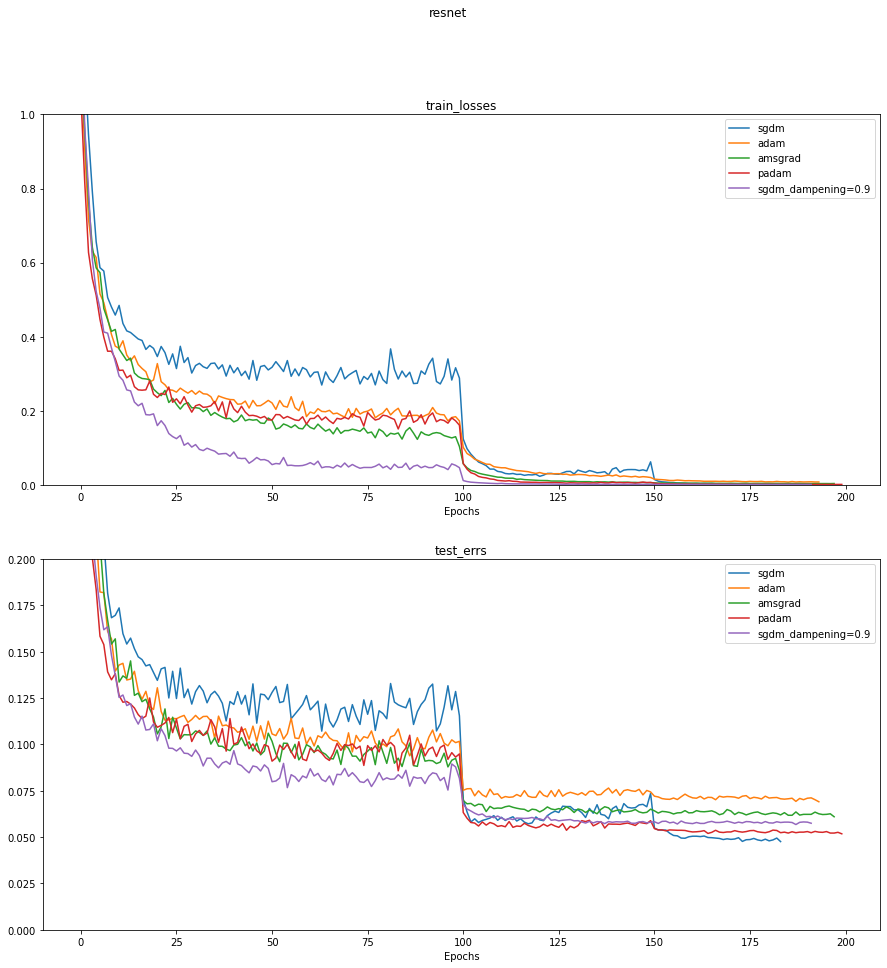

In [ ]:
plot_re('resnet',methods=['sgdm','adam','amsgrad','padam','sgdm_dampening=0.9'])

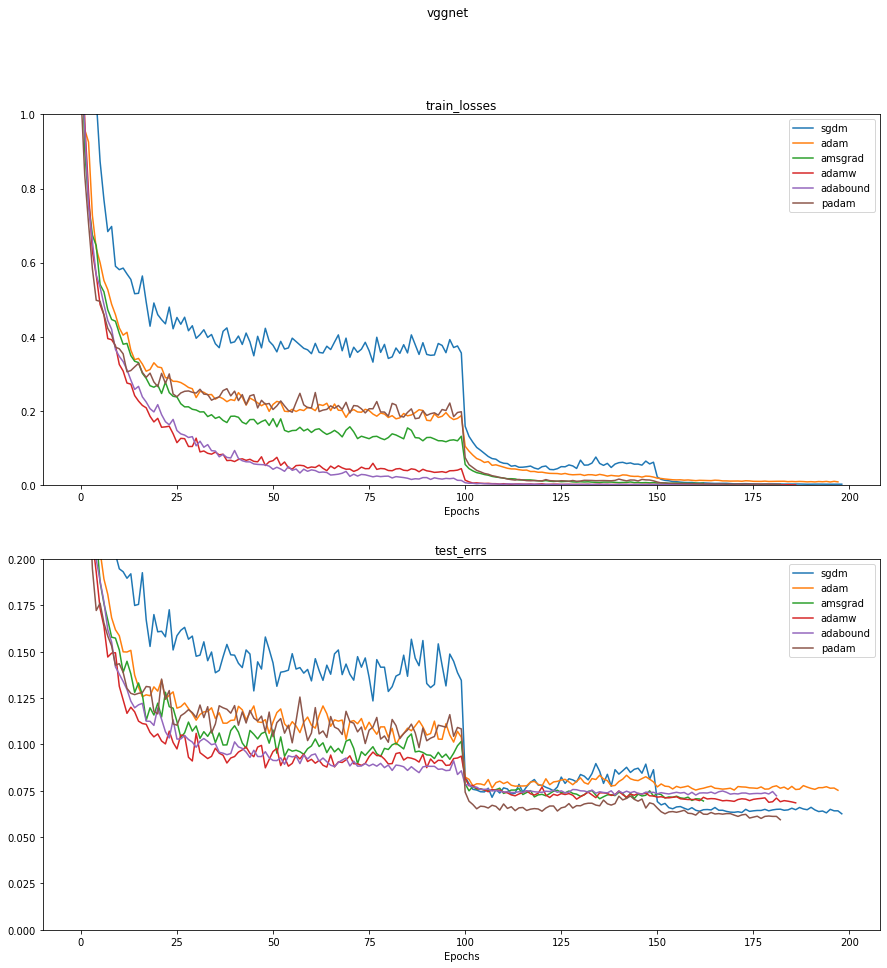

In [ ]:
plot_re('vggnet')


In [ ]:
#@title CIFAR-100 padam
lr=0.1
method="padam"
resume=True
net="vggnet"
partial=0.125
wd=5e-4
Nepoch=200
beta1=0.9
beta2=0.999

class Args:
  def __init__(self,lr,method,resume,net,partial,wd,Nepoch,beta1,beta2) -> None:
    self.lr=lr
    self.method=method
    self.resume=resume
    self.net=net
    self.partial=partial
    self.wd=wd
    self.Nepoch=Nepoch
    self.beta1=beta1
    self.beta2=beta2

args=Args(lr,method,resume,net,partial,wd,Nepoch,beta1,beta2)

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_errs = []
test_errs = []
train_losses = []
test_losses = []


print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])


trainset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root=path+'/data/CIFAR100', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

  
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    # assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(path+'/checkpoint/cnn_cifar100_'+args.method)
    model = checkpoint['model']
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    train_errs = checkpoint['train_errs']
    test_errs = checkpoint['test_errs']
else:
    print('==> Building model..')
    if args.net == 'vggnet':
        model = VGG('VGG16', num_classes = 100)
    elif args.net == 'resnet':
        model = ResNet18(num_classes = 100)
    elif args.net == 'wideresnet':
        model = WResNet_cifar10(num_classes = 100, depth=16, multiplier=4)
    else:
        print ('Network undefined!')


if use_cuda:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    

criterion = nn.CrossEntropyLoss()

betas = (args.beta1, args.beta2)
if args.method == 'sgdm':
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum= 0.9, weight_decay = args.wd)
elif args.method == 'adam':
    from torch.optim import Adam
    optimizer = Adam.Adam(model.parameters(), lr=args.lr, weight_decay = args.wd, betas = betas)
elif args.method == 'adamw':
    from torch.optim import AdamW
    optimizer = AdamW.AdamW(model.parameters(), lr=args.lr, weight_decay = args.wd, betas = betas)
elif args.method == 'amsgrad':
    from torch.optim import Adam
    optimizer = Adam.Adam(model.parameters(), lr=args.lr, amsgrad = True, weight_decay = args.wd, betas = betas)
elif args.method == 'padam':
    optimizer = Padam(model.parameters(), lr=args.lr, partial = args.partial, weight_decay = args.wd, betas = betas)
else:
    print ('Optimizer undefined!')
    
scheduler = MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)

for epoch in range(start_epoch+1, args.Nepoch+1):
    
    scheduler.step() 
    print ('\nEpoch: %d' % epoch, ' Learning rate:', scheduler.get_lr())
    model.train()  # Training

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        def closure():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            return loss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step(closure)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.0/total*float(correct), correct, total))
 
    # Compute training error 
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.0/total*(correct), correct, total))
    train_errs.append(1 - correct/total)
    train_losses.append(train_loss/(batch_idx+1))

    model.eval() # Testing
 
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()

        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.0/total*(correct), correct, total))
    test_errs.append(1 - correct/total)
    test_losses.append(test_loss/(batch_idx+1))

    # Save checkpoint
    acc = 100.0/total*(correct)
    if acc > best_acc:
        print('Saving..')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        state = {
                'model': model,
                'epoch': epoch,
                'train_errs':train_errs,
                'test_errs':test_errs,
                'train_losses':train_losses,
                'test_losses':test_losses
                }
        torch.save(state, path+'/checkpoint/cnn_cifar100_' + args.method)
        best_acc = acc
  

In [ ]:
checkpoint = torch.load(path + '/checkpoint/cnn_cifar10_padam')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(checkpoint['train_errs'], label='train_errs')
ax.plot(checkpoint['test_errs'], label='test_errs')
ax.legend()
ax.set_xlabel('$X$')
plt.show()

In [ ]:
checkpoint = torch.load(path + '/checkpoint/resnet/cnn_cifar10_adam')

In [ ]:
checkpoint['lr']

[1e-05]

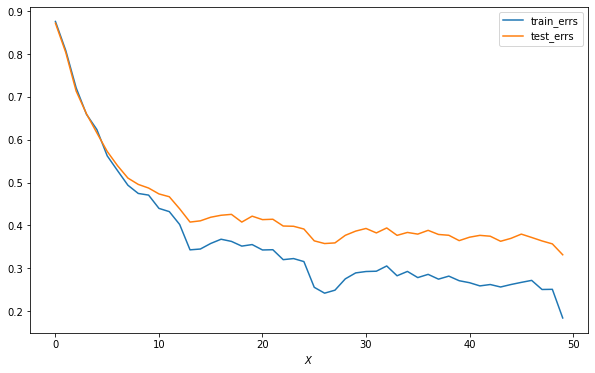

In [ ]:
checkpoint = torch.load(path + '/checkpoint/cnn_cifar100_padam')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(checkpoint['train_errs'], label='train_errs')
ax.plot(checkpoint['test_errs'], label='test_errs')
ax.legend()
ax.set_xlabel('$X$')
plt.show()

In [ ]:
checkpoint['epoch']

198

In [ ]:
checkpoint['train_errs']